# Réduction de Dimensionnalité et Analyse d'Image avec PCA, UMAP et RandomForest

Ce notebook initie par une phase de préparation des données, avant de s'engager dans des méthodes de réduction de dimension via PCA et UMAP. Il procède ensuite à l'entraînement d'un modèle RandomForest sur l'ensemble de données original ainsi que sur celui transformé par PCA, évaluant leur performance à travers des rapports de classification et des matrices de confusion. En conclusion, il met en œuvre une visualisation des données transformées dans un espace bidimensionnel grâce à PCA et UMAP, démontrant ainsi l'utilité de ces méthodes pour la visualisation et l'optimisation potentielle de la performance des modèles de machine learning.

In [1]:
# Importation des modules
import os
import pandas as pd
import cv2
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [6]:
import umap

In [2]:
# Configuration des chemins et chargement des données
path = "../../data/raw/images/image_train"

# Chargement des métadonnées et des étiquettes
X = pd.read_csv(r"../../data/processed/X_train_update (komla).csv", index_col=0)
y = (
    pd.read_csv(r"../../data/processed/Y_train_CVw08PX (komla).csv", index_col=0)
    .squeeze()
    .map(str)
)

# Ajout du chemin complet vers chaque image dans le DataFrame X
X["image_path"] = X.apply(
    lambda row: os.path.join(path, f"image_{row.imageid}_product_{row.productid}.jpg"),
    axis=1,
)

In [3]:
# Prétraitement des images

# Paramètres pour le redimensionnement
image_size = (50, 50)


# Fonction pour lire et redimensionner une image
def process_image(image_path):
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_gray_resized = cv2.resize(img_gray, image_size, interpolation=cv2.INTER_AREA)
    return img_gray_resized


# Liste des chemins d'images à traiter
path_list = X["image_path"].tolist()

# Utilisation de ThreadPoolExecutor pour traiter les images en parallèle
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    images_resized = list(executor.map(process_image, path_list))

In [4]:
# Construction des données du DataFrame


# Fonction pour convertir les images en une liste de valeurs de pixels
def image_to_pixel_list(image, idx, label):
    pixel_list = [idx, label]
    for row in image:
        for pixel in row:
            pixel_list.append(pixel)
    return pixel_list


# Préparation des données pour le DataFrame
data_for_df = [
    image_to_pixel_list(image, idx, label)
    for image, idx, label in zip(images_resized, X.index, y)
]

# Création des noms de colonnes
column_names = ["index", "label"] + [
    f"pixel{i+1}" for i in range(image_size[0] * image_size[1])
]

In [5]:
# Création du DataFrame

# Initialisation du DataFrame vide avec des types spécifiés pour économiser de la mémoire
column_types = {
    f"pixel{i}": "uint8" for i in range(1, image_size[0] * image_size[1] + 1)
}
column_types["index"] = int
column_types["label"] = str

# Préparation d'une liste pour recueillir les DataFrames de lots
df_list = []

# Taille du lot pour le traitement par morceaux
batch_size = 5000

# Traitement par lots
for start in range(0, len(data_for_df), batch_size):
    end = start + batch_size
    batch_data = data_for_df[start:end]
    batch_df = pd.DataFrame(batch_data, columns=column_names)
    # Assurez-vous que les types sont corrects
    batch_df = batch_df.astype(column_types)
    df_list.append(batch_df)

# Concaténez tous les DataFrames de la liste en une seule opération
rakuten_images_df = pd.concat(df_list, ignore_index=True)

In [6]:
display(rakuten_images_df.head())

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel2491,pixel2492,pixel2493,pixel2494,pixel2495,pixel2496,pixel2497,pixel2498,pixel2499,pixel2500
0,0,10,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,1,2280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,2,50,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,3,1280,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,2705,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [7]:
# Sauvegarde du DataFrame en CSV
rakuten_images_df.to_csv("rakuten_images_processed.csv", index=False)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

This is taking too long, we give up.



In [8]:
# Charger le df stocké:

rakuten_images_processed = pd.read_csv("rakuten_images_processed.csv")
rakuten_images_processed.drop(columns=["index"], inplace=True)

In [9]:
rakuten_images_processed.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2491,pixel2492,pixel2493,pixel2494,pixel2495,pixel2496,pixel2497,pixel2498,pixel2499,pixel2500
0,10,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,2280,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,50,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,1280,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,2705,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [10]:
# Creation des variables et target:
target = rakuten_images_processed["label"]
data = rakuten_images_processed.drop("label", axis=1)

# PCA

In [11]:
import mlflow

mlflow.set_tracking_uri("../../mlruns")
mlflow.set_experiment("SVM PCA")
mlflow.sklearn.autolog(log_datasets=False)

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1313, in _read_helper
    result = read_yaml(root, file_name)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 310, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file '../../mlruns/3826220

2024/05/05 16:03:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'caa4c2de8c244d1d8dbfdb9db1889f24', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/05 16:04:22 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/05/05 16:04:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a 

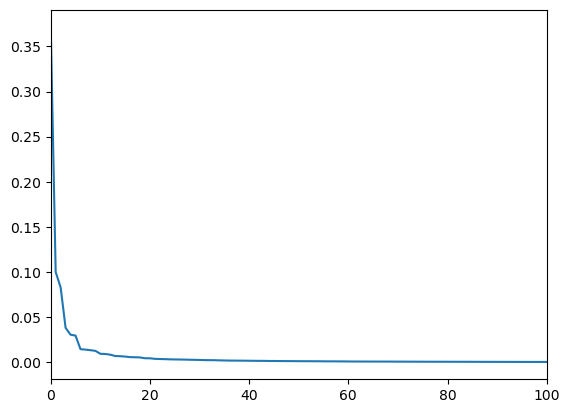

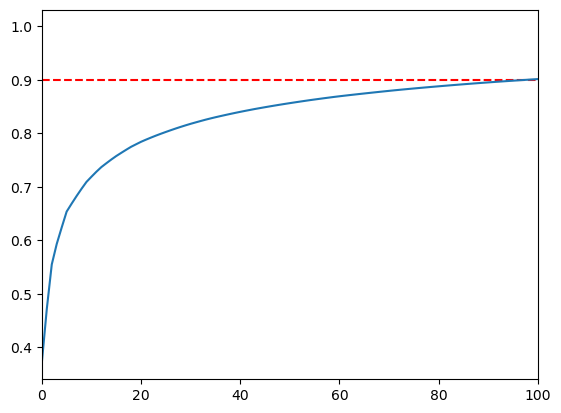

In [12]:
# Analyse de l'impact de la réduction de variables sur la variance du dataset:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import itertools  # Pour créer des iterateurs
from sklearn.metrics import f1_score, make_scorer, classification_report

pca = PCA()
pca.fit(data)

plt.figure()
plt.xlim(0, 100)
plt.plot(pca.explained_variance_ratio_)

plt.figure()
plt.xlim(0, 100)
plt.axhline(y=0.90, color="r", linestyle="--")
plt.plot(pca.explained_variance_ratio_.cumsum())

In [13]:
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=0.90)
pca.fit(data)
print("Nombre de composantes retenues :", pca.n_components_)

2024/05/05 16:04:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '74807dffea614ba2a03ee859a166ce3d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/05 16:05:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/05/05 16:05:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a 

Nombre de composantes retenues : 99


In [14]:
display(data)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel2491,pixel2492,pixel2493,pixel2494,pixel2495,pixel2496,pixel2497,pixel2498,pixel2499,pixel2500
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84911,255,255,255,255,255,255,255,84,15,22,...,15,18,85,255,255,255,255,255,255,255
84912,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
84913,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
84914,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [15]:
# Imprimer la part de variance expliquée par les composantes PCA retenues
print(
    "La part de variance expliquée est", round(pca.explained_variance_ratio_.sum(), 2)
)

La part de variance expliquée est 0.9


In [16]:
# Projection des données dans le nouveau space avec 99 varaibles

X_train = data[:67933]  # 67933=84916*80%
X_test = data[67933:]

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

2024/05/05 16:05:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd54964eb7ed04f1b974f75b944473365', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/05 16:05:45 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/05/05 16:05:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a 

In [17]:
y_train = y[:67933]
y_test = y[67933:]

# Entrainement d'un modèle 

- Dataset complet

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_jobs=-1)

with mlflow.start_run() as run:
    print("Run id:", run.info.run_id)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    # View the classification report for test data and predictions
    print(classification_report(y_test, y_pred_test))
clf.score(X_test, y_test)

Run id: 8c13f9060b2647b7acfa73de49f9b5d7


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
2024/05/05 16:06:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-

              precision    recall  f1-score   support

          10       0.45      0.54      0.49       641
        1140       0.51      0.26      0.34       533
        1160       0.69      0.71      0.70       828
        1180       0.62      0.10      0.17       161
        1280       0.22      0.17      0.19       959
        1281       0.24      0.04      0.07       433
        1300       0.42      0.57      0.48      1009
        1301       0.66      0.24      0.35       162
        1302       0.53      0.17      0.26       452
        1320       0.35      0.25      0.29       617
        1560       0.33      0.38      0.35       977
        1920       0.74      0.68      0.71       828
        1940       0.74      0.15      0.26       181
        2060       0.32      0.43      0.37       966
        2220       1.00      0.09      0.17       173
        2280       0.50      0.60      0.54       949
        2403       0.34      0.61      0.44       964
        2462       0.44    

0.4657598775245834

In [ ]:
# Création d'une fonction propre pour la confusion matrix

# Variable target avec les labels organisées
y_organised = [
    "10",
    "2280",
    "2403",
    "2705",
    "2522",
    "40",
    "50",
    "2905",
    "2462",
    "60",
    "1280",
    "1281",
    "1300",
    "1180",
    "1140",
    "1160",
    "1320",
    "1560",
    "2582",
    "2583",
    "2585",
    "1302",
    "2220",
    "1920",
    "2060",
    "1301",
    "1940",
]


def conf_matx(y_test, y_pred):

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=y_organised)
    y_organised

    pond_matrix = []
    for line in cnf_matrix:
        pond_line = []
        for cell in line:
            pond_line.append(round(cell / sum(line), 2))
        pond_matrix.append(pond_line)
        # print(sum(line))
        # print(sum(pond_line))
    cnf_matrix = np.array(pond_matrix)

    ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
    # classes = set(y_pred)
    classes = y_organised

    plt.figure(figsize=(10, 10))

    plt.imshow(cnf_matrix, interpolation="nearest", cmap="Blues")
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    # tick_marks = set(y_test)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(
        range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])
    ):
        plt.text(
            j,
            i,
            cnf_matrix[i, j],
            horizontalalignment="center",
            color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black",
        )

    plt.ylabel("Vrais labels")
    plt.xlabel("Labels prédits")
    plt.show()

In [ ]:
# Évaluation du modèle sur l'ensemble de test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matx(y_test, y_pred)  # montre les résultats en pourcentages!

- Dataset reduit:

In [19]:
clf_red = RandomForestClassifier(n_jobs=-1)

with mlflow.start_run() as run:
    print("Run id:", run.info.run_id)
    clf_red.fit(X_train_pca, y_train)
    y_pred_test = clf_red.predict(X_test_pca)
    # View the classification report for test data and predictions
    print(classification_report(y_test, y_pred_test))

clf_red.score(X_test_pca, y_test)

Run id: 1da3cf6c5aad44178aef5068045dc460


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


              precision    recall  f1-score   support

          10       0.45      0.45      0.45       641
        1140       0.41      0.18      0.25       533
        1160       0.59      0.68      0.63       828
        1180       0.71      0.06      0.11       161
        1280       0.14      0.11      0.12       959
        1281       0.26      0.02      0.04       433
        1300       0.39      0.46      0.42      1009
        1301       0.72      0.19      0.30       162
        1302       0.60      0.12      0.19       452
        1320       0.31      0.18      0.22       617
        1560       0.28      0.30      0.29       977
        1920       0.55      0.64      0.59       828
        1940       0.73      0.09      0.16       181
        2060       0.28      0.40      0.33       966
        2220       1.00      0.08      0.14       173
        2280       0.37      0.57      0.45       949
        2403       0.32      0.57      0.41       964
        2462       0.53    

0.4119413531178237

In [24]:
report = classification_report(y_test, y_pred_test, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("report_pca_2_components.csv")

In [ ]:
y_pred = clf_red.predict(X_test_pca)
print(classification_report(y_test, y_pred))
conf_matx(y_test, y_pred)  # montre les résultats en pourcentages!

In [ ]:
# Réduction de dimensionnalité avec PCA à deux composantes pour visualisation
pca = PCA(n_components=2)
data_2D = pca.fit_transform(data)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(data_2D[:, 0], data_2D[:, 1], c=target, cmap=plt.cm.Spectral)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show()

# UMAP

In [ ]:
pip install umap-learn


In [ ]:
# Réduction de dimensionnalité avec UMAP pour la visualisation
import umap

reducer = umap.UMAP(n_neighbors=50, n_components=2, random_state=42)
dataUMAP = reducer.fit_transform(data)

In [ ]:
# Visualisation des données réduites avec UMAP
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(
    dataUMAP[:, 0], dataUMAP[:, 1], c=target, cmap=plt.cm.Spectral, alpha=0.7, s=4
)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

ax.set_title("Manifold 2D identifié par la UMAP")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Fonction pour visualiser des données en 2D avec des images comme annotations.


def plot_components(
    data, model, images=None, ax=None, thumb_frac=0.05, cmap="gray_r", prefit=False
):
    ax = ax or plt.gca()

    # Transforme les données si prefit=False, sinon utilise les données projetées directement
    if not prefit:
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], ".b")  # Dessine les points projetés

    # Si des images sont fournies, les ajoute au graphique
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array(
            [2 * proj.max(0)]
        )  # Initialise avec une valeur hors portée
        for i in range(data.shape[0]):  # Itère sur chaque point projeté
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if (
                np.min(dist) < min_dist_2
            ):  # Vérifie la distance minimum pour éviter le surpeuplement
                continue  # Passe au point suivant si trop proche
            shown_images = np.vstack(
                [shown_images, proj[i]]
            )  # Ajoute le point à la liste des points affichés
            imagebox = AnnotationBbox(
                OffsetImage(images[i], cmap=cmap), proj[i], frameon=False
            )  # Crée une boîte d'annotation pour l'image
            ax.add_artist(imagebox)  # Ajoute l'image au graphique


# visualiser les résultats de la réduction de dimension avec UMAP
fig, ax = plt.subplots(figsize=(12, 12))
plot_components(
    data=dataUMAP,
    model=reducer,
    images=data.values.reshape((-1, 50, 50)),
    ax=ax,
    thumb_frac=0.05,
    prefit=True,
)